In [9]:
!pip install pandas scikit-learn xgboost matplotlib seaborn streamlit shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [41]:
import pandas as pd
import sklearn as sk
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import shap
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv('/content/sample_data/food_adulteration_data.csv')
df.head()

,adulteration_id,product_name,brand,category,adulterant,detection_date,detection_method,severity,health_risk,action_taken
0,1,Butter,BrandB,Meat,Artificial sweeteners,5/11/2024,Microbiological Analysis,Moderate,Low,Product Recall
1,2,Chicken,BrandC,Dairy,Coloring agents,5/23/2024,Sensory Evaluation,Severe,Medium,Warning Issued
2,3,Yogurt,BrandC,Meat,Artificial sweeteners,2/17/2024,Sensory Evaluation,Severe,High,Investigation Launched
3,4,Wine,BrandB,Beverages,Coloring agents,5/16/2024,Spectroscopy,Minor,Medium,Product Recall
4,5,Bread,BrandD,Dairy,Water,6/6/2024,Chemical Analysis,Severe,Medium,Warning Issued


In [24]:
df.info()
print(df.isnull().sum())
print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   adulteration_id   1000 non-null   int64 
 1   product_name      1000 non-null   object
 2   brand             1000 non-null   object
 3   category          1000 non-null   object
 4   adulterant        1000 non-null   object
 5   detection_date    1000 non-null   object
 6   detection_method  1000 non-null   object
 7   severity          1000 non-null   object
 8   health_risk       1000 non-null   object
 9   action_taken      1000 non-null   object
dtypes: int64(1), object(9)
memory usage: 78.3+ KB
adulteration_id     0
product_name        0
brand               0
category            0
adulterant          0
detection_date      0
detection_method    0
severity            0
health_risk         0
action_taken        0
dtype: int64
adulteration_id     1000
product_name          10
brand   

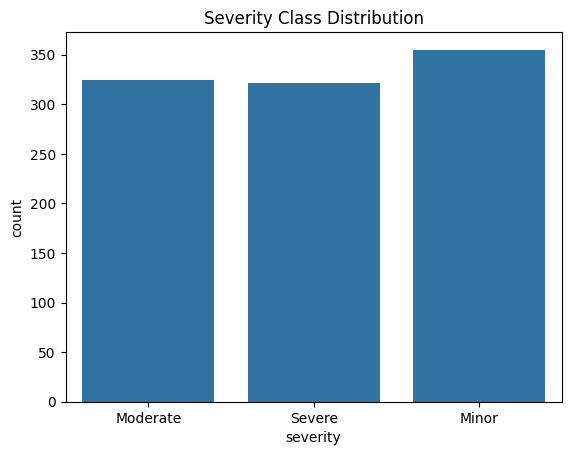

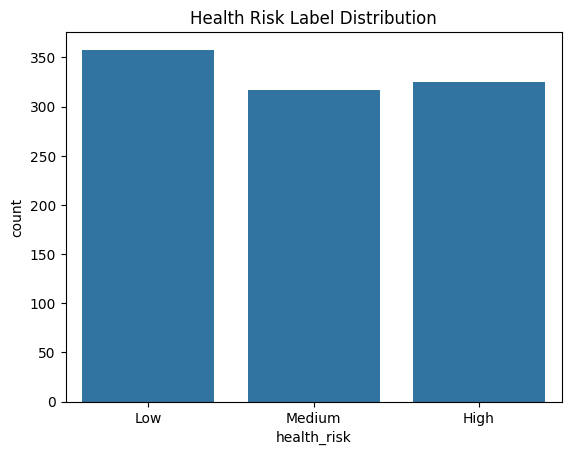

In [25]:
sns.countplot(data=df, x='severity')
plt.title('Severity Class Distribution')
plt.show()

sns.countplot(data=df, x='health_risk')
plt.title('Health Risk Label Distribution')
plt.show()

In [26]:
# Binary target
df['is_adulterated'] = 1  # All rows contain an adulterant in this dataset

# Date to datetime and derive features
df['detection_date'] = pd.to_datetime(df['detection_date'])
df['month'] = df['detection_date'].dt.month
df['year'] = df['detection_date'].dt.year

In [27]:
# for dropping the unnecessary data which can't be used for training
drop_cols = ['adulteration_id', 'detection_method', 'action_taken', 'detection_date']
df = df.drop(columns=drop_cols)

In [29]:
target = 'severity'  # Or 'health_risk' or your chosen label
X = df.drop(columns=[target, 'is_adulterated'])  # Drop all target variables you are NOT using
y = df[target]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [36]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns

preproc = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [42]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [43]:
for name, clf in models.items():
    pipe = Pipeline([('pre', preproc), ('model', clf)])
    if name == 'XGBoost':
        # Use encoded labels for XGBoost
        pipe.fit(X_train, y_train_enc)
        preds = pipe.predict(X_val)
        print(f"{name}: F1 Score = {f1_score(y_val_enc, preds, average='macro'):.3f}")
    else:
        # Use original string labels for other models
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)
        print(f"{name}: F1 Score = {f1_score(y_val, preds, average='macro'):.3f}")

Random Forest: F1 Score = 0.370


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:11:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: F1 Score = 0.332


In [45]:
# test code
# XGBoost on test set:
xgb_pipe = Pipeline([('pre', preproc), ('model', models['XGBoost'])])
xgb_pipe.fit(X_train, y_train_enc)
y_pred = xgb_pipe.predict(X_test)
# Use y_test_enc and y_pred for evaluations
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
named_preds = le.inverse_transform(y_pred)
print(pd.Series(named_preds).value_counts())

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:13:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


NameError: name 'classification_report' is not defined

In [44]:
# better model training
models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(tree_method='hist', eval_metric='mlogloss', random_state=42, use_label_encoder=False)
}



for name, clf in models.items():
    pipe = Pipeline([('pre', preproc), ('model', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    print(f"{name}: F1 Score = {f1_score(y_val, preds, average='macro'):.3f}")

Random Forest: F1 Score = 0.370


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['Minor' 'Moderate' 'Severe']